In [55]:
import httpx
import json
from PIL import Image
from io import BytesIO


class UnsupportedMediaTypeError(Exception): pass
class BadRequestError(Exception): pass
class ForbiddenError(Exception): pass
class NotFoundError(Exception): pass
class RequestTimeoutError(Exception): pass
class InternalServerError(Exception): pass


error_code_and_ex={
    415: UnsupportedMediaTypeError,
    400: BadRequestError,
    403: ForbiddenError,
    404: NotFoundError,
    408: RequestTimeoutError,
    500: InternalServerError,
}

class HttpProxy(object):
    
    def __init__(self, host, port):
        self._host = host
        self._port = port
        self._base_url = 'http://' + self._host + ':' + str(self._port)
        pass

    def do_response(self, response):
        if response.status_code == 200:
            ct = response.headers.get('content-type', None)
            if ct and ct == 'application/json':
                return response.json()
            elif ct and ct == 'image/png':
                return Image.open(BytesIO(response.content)).convert('RGB')
        else:
            raise error_code_and_ex[response.status_code]()
    
    def get(self, url):
        with httpx.Client() as client:
            return self.do_response(client.get(self._base_url + url))                
        return None

    def delete(self, url):
        with httpx.Client() as client:
            return self.do_response(client.delete(self._base_url + url))                
        return None

    def create(self, url, data):
        with httpx.Client() as client:
            self.do_response(client.create(self._base_url + url,
                                    data=json.dumps(data),
                                   headers={"Content-Type": "application/json"}
                                   ))
        return None
        
    def post(self, url, data):
        with httpx.Client() as client:
            self.do_response(client.post(self._base_url + url,
                                    data=json.dumps(data),
                                   headers={"Content-Type": "application/json"}
                                   ))
        return None

    def patch(self, url, data):
        with httpx.Client() as client:
            self.do_response(client.patch(self._base_url + url,
                                    data=json.dumps(data),
                                   headers={"Content-Type": "application/json"}
                                   )) 
        return None

class SystemProxy(HttpProxy):

    def __init__(self, host, port):
        super().__init__(host, port)
        self._processes = None
        self._containers = None
        self._container_processes = None
        pass

    def profile_full(self, update=False):
        return self.get('/api/system/profile_full')

    def create_process(self, type_name, name, use_memo=True):
        return self.create('/api/process/', {
            "type_name": type_name,
            "name": name,
            "use_memo": use_memo})
        
    def processes(self):
        ps = self.get('/api/process/list')
        return ps

    def containers(self, update=False):
        ps = self.get('/api/container/list')
        if self._containers is None or update:
            self._containers = [ContainerProxy(self, p) for p in ps]
        return self._containers

    def container_processes(self, update=False):
        ps = self.get('/api/container_process/list')
        if self._container_processes is None or update:
            self._container_processes = [ContainerProcessProxy(self, p) for p in ps]
        return self._container_processes

class ObjectProxy(object):
    
    def __init__(self, system_proxy, class_name, identifier):
        self._system_proxy = system_proxy
        self._identifier = identifier
        self._class_name = class_name
        self._profile = None

    def profile_full(self, update=False):
        if self._profile is None or update:
            self._profile = self._system_proxy.get('/api/' + self._class_name + '/profile_full?identifier=' + self._identifier)
        return self._profile

    def identifier(self, update=False):
        p = self.profile_full(update=update)
        return p['identifier']

    def destroy(self):
        return self._system_proxy.delete('/api/' + self._class_name + '/destroy?identifier=' + self._identifier)

class ProcessProxy(ObjectProxy):
    def __init__(self, system_proxy, identifier):
        super().__init__(system_proxy, 'process', identifier)    

    def call(self, *args, **kwargs):
        return self._system_proxy.patch('/api/' + self._class_name + '/call?identifier=' + self._identifier, data=kwargs)

    def execute(self):
        return self._system_proxy.patch('/api/' + self._class_name + '/execute?identifier=' + self._identifier, data={})

    def __repr__(self):
        return f'Process("{self.identifier()}")'

class ContainerProxy(ObjectProxy):
    def __init__(self, system_proxy, identifier):
        super().__init__(system_proxy, 'container', identifier)    

    def __repr__(self):
        return f'Container("{self.identifier()}")'
        
class ContainerProcessProxy(ObjectProxy):
    def __init__(self, system_proxy, identifier):
        super().__init__(system_proxy, 'container_process', identifier)    

    def call(self, **kwargs): 
        return self._system_proxy.patch('/api/' + self._class_name + '/call?identifier=' + self._identifier, data=kwargs)

    def execute(self):
        return self._system_proxy.patch('/api/' + self._class_name + '/execute?identifier=' + self._identifier, data={})
        pass

    def __repr__(self):
        return f'ContainerProcess("{self.identifier()}")'


class IdentifierStruct(object):

    def __init__(self, broker_type, broker_name, class_name, type_name, name):
        self.broker_type = broker_type
        self.broker_name = broker_name
        self.class_name = class_name
        self.type_name = type_name
        self.name = name

    @classmethod
    def fromIdentifier(self, id):
        s, type_name = id.split('::')
        broker_type, s2 = s.split('://')
        broker_name, class_name, name = s2.split('/')
        return IdentifierStruct(broker_type, broker_name, class_name, type_name, name)

    def to_id(self):
        return f'{self.broker_type}://{self.broker_name}/{self.class_name}/{self.name}::{self.type_name}'

    def __repr__(self):
        return f'IdentifierStruct(broker_type="{self.broker_type}",broker_name="{self.broker_name}",class_name="{self.class_name}",type_name="{self.type_name}",name="{self.name}")'


In [40]:
import yaml
sp = SystemProxy('localhost', 8000)

print(yaml.safe_dump(sp.profile_full(), default_flow_style=False))



class_name: BrokerProxy
core_store:
  broker_factories:
    http:
      class_name: BrokerFactory
      identifier: core://core/BrokerFactory/http::http
      name: http
      type_name: http
    local:
      class_name: BrokerFactory
      identifier: core://core/BrokerFactory/local::local
      name: local
      type_name: local
  brokers:
    http:
      class_name: Broker
      identifier: core://core/Broker/0.0.0.0:8000::http
      name: 0.0.0.0:8000
      type_name: http
    local:
      class_name: Broker
      identifier: core://core/Broker/local::local
      name: local
      type_name: local
  container_factories:
    cv_filesystem:
      class_name: ContainerFactory
      container_factory:
        class_name: ContainerFactory
        identifier: core://core/ContainerFactory/cv_filesystem::cv_filesystem
        name: cv_filesystem
        type_name: cv_filesystem
      identifier: core://core/ContainerFactory/cv_filesystem::cv_filesystem
      name: cv_filesystem
      plugi

In [66]:
id = "core://core/ContainerProcess/read0::cv_video_capture_read"
s = IdentifierStruct.fromIdentifier(id)
print(id)
print(s)
print(s.to_id())

core://core/ContainerProcess/read0::cv_video_capture_read
IdentifierStruct(broker_type="core",broker_name="core",class_name="ContainerProcess",type_name="cv_video_capture_read",name="read0")
core://core/ContainerProcess/read0::cv_video_capture_read


In [124]:
sp = SystemProxy('localhost', 8000)
cs = sp.containers()
print(cs)
cps = sp.container_processes()
print(cps)


[Container("core://core/Container/cv_window0::cv_window"), Container("core://core/Container/cv_camera0::cv_video_capture"), Container("core://core/Container/cv_filesystem0::cv_filesystem")]
[ContainerProcess("core://core/ContainerProcess/imshow0::imshow"), ContainerProcess("core://core/ContainerProcess/imwrite0::imwrite"), ContainerProcess("core://core/ContainerProcess/read0::cv_video_capture_read")]


In [125]:
cps[1].destroy()

{'arguments': {'filename': {'default': 'img.png',
   'description': '',
   'name': 'filename',
   'type': 'string'},
  'src': {'default': {}, 'description': '', 'name': 'src', 'type': 'object'}},
 'class_name': 'ContainerProcess',
 'container_identifier': 'core://core/Container/cv_filesystem0::cv_filesystem',
 'identifier': 'core://core/ContainerProcess/imwrite0::imwrite',
 'inlets': [{'name': 'filename', 'source_connections': []},
  {'name': 'src',
   'source_connections': [{'arg_name': 'src',
     'destination_identifier': 'core://core/ContainerProcess/imwrite0::imwrite',
     'identifier': 'connection://core://core/ContainerProcess/read0::cv_video_capture_read|src|core://core/ContainerProcess/imwrite0::imwrite',
     'source_process_identifier': 'core://core/ContainerProcess/read0::cv_video_capture_read',
     'type': 'Pull'}]}],
 'name': 'imwrite0',
 'outlet': {'destination_connections': []},
 'type_name': 'imwrite'}

class_name: BrokerProxy
core_store:
  broker_factories:
    http:
      class_name: BrokerFactory
      identifier: core://core/BrokerFactory/http::http
      name: http
      type_name: http
    local:
      class_name: BrokerFactory
      identifier: core://core/BrokerFactory/local::local
      name: local
      type_name: local
  brokers:
    http:
      class_name: Broker
      identifier: core://core/Broker/0.0.0.0:8000::http
      name: 0.0.0.0:8000
      type_name: http
    local:
      class_name: Broker
      identifier: core://core/Broker/local::local
      name: local
      type_name: local
  container_factories:
    cv_filesystem:
      class_name: ContainerFactory
      container_factory:
        class_name: ContainerFactory
        identifier: core://core/ContainerFactory/cv_filesystem::cv_filesystem
        name: cv_filesystem
        type_name: cv_filesystem
      identifier: core://core/ContainerFactory/cv_filesystem::cv_filesystem
      name: cv_filesystem
      plugi

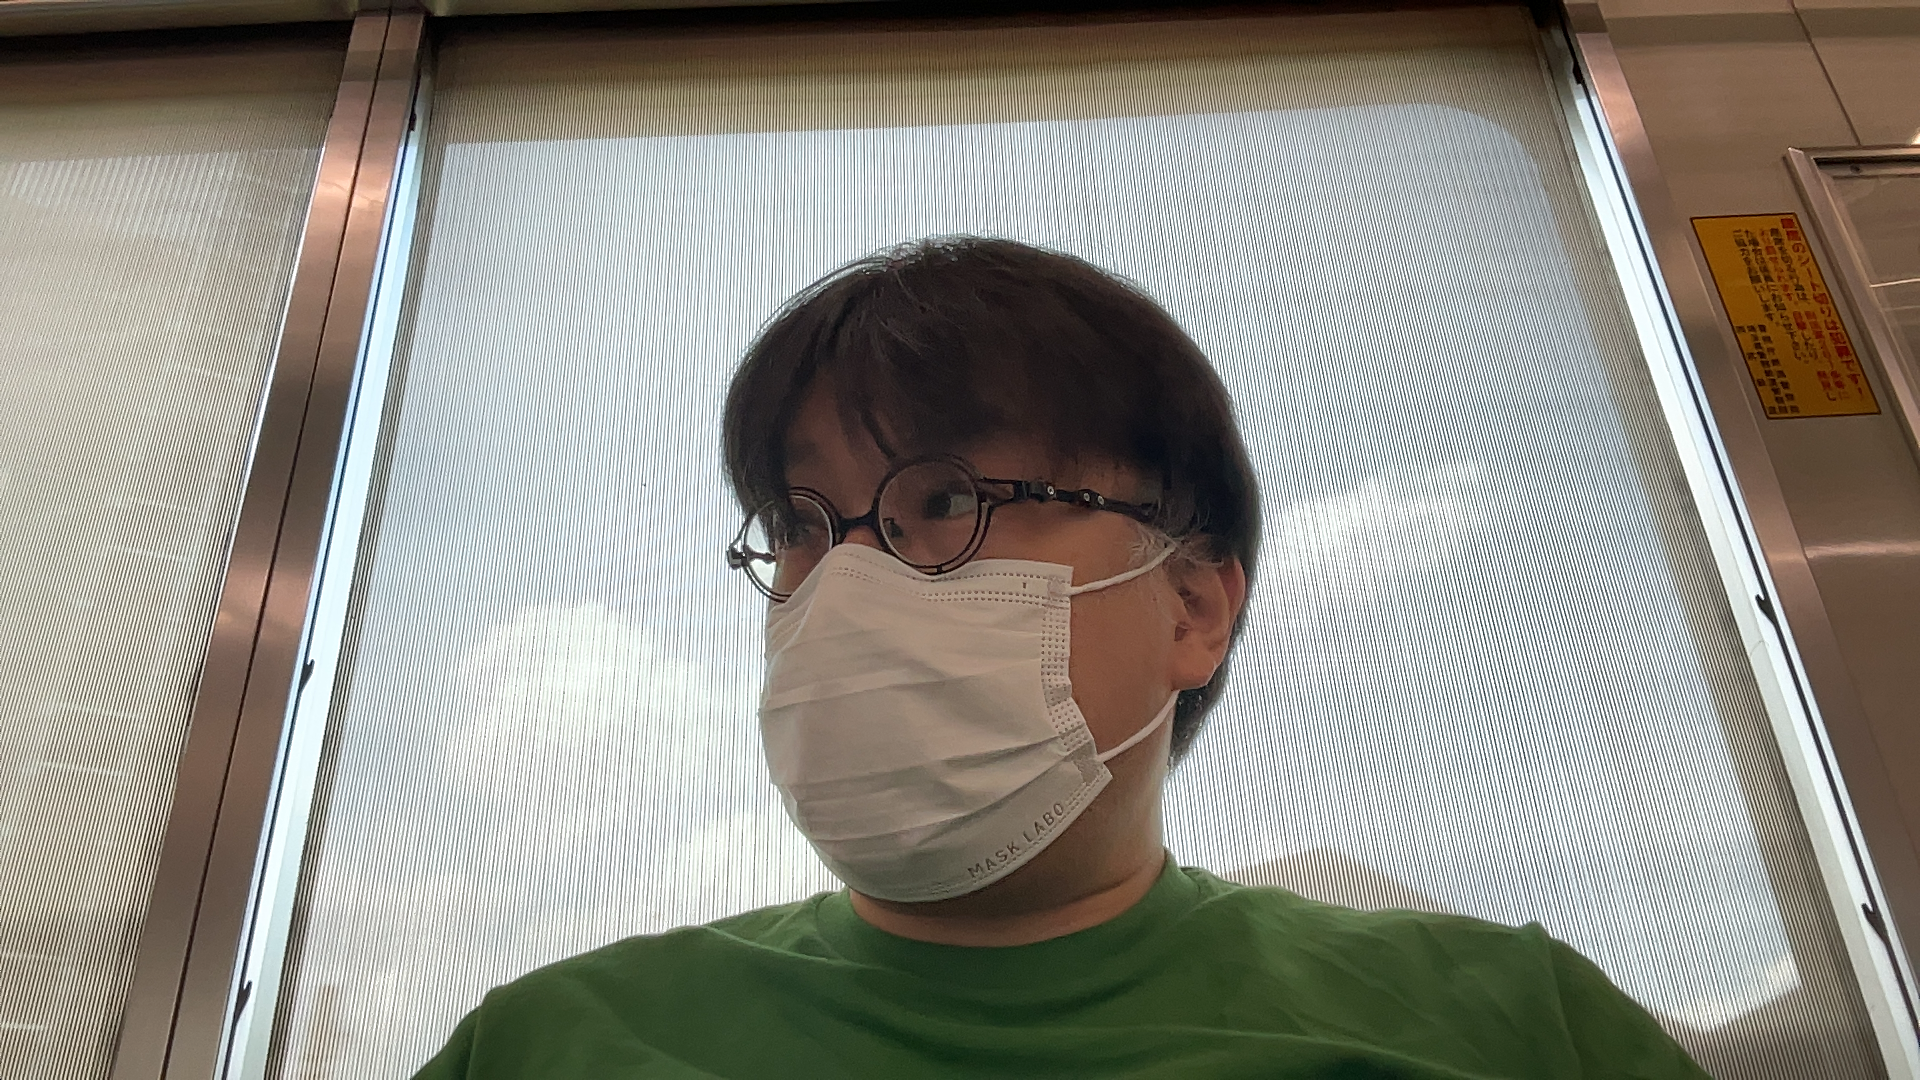

In [47]:
import yaml
sp = SystemProxy('localhost', 8000)

print(yaml.safe_dump(sp.profile_full(), default_flow_style=False))

ps = sp.container_processes()
p = ps[2]
p.identifier()
p.execute()





In [56]:
#d
